<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


In [1]:
from PIL import Image, ImageChops
import os
import numpy as np
import pandas as pd
import cv2
from skimage import io
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "dark", 
        color_codes = True,
        font_scale = 1.5)

import warnings
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.random.seed(42)

### Reading images from datasets

In [2]:
from ipynb.fs.full.GradProject_NB1 import read_training_data, read_testing_data

In [105]:
training_data, label_dict = read_training_data()
testing_data = read_testing_data()
print(" Dataset dimensions:")
print(f"\tTraining data: {training_data.shape}")
print(f"\tTesting data: {testing_data.shape}")

Reading training images
	- Fetching label 'airplanes'
	- Fetching label 'bear'
	- Fetching label 'blimp'
		- Gray image ('blimp_0022.jpg') was loaded, converting to RGB
	- Fetching label 'comet'
		- Gray image ('comet_0006.jpg') was loaded, converting to RGB
		- Gray image ('comet_0011.jpg') was loaded, converting to RGB
		- Gray image ('comet_0013.jpg') was loaded, converting to RGB
		- Gray image ('comet_0021.jpg') was loaded, converting to RGB
		- Gray image ('comet_0036.jpg') was loaded, converting to RGB
		- Gray image ('comet_0038.jpg') was loaded, converting to RGB
		- Gray image ('comet_0041.jpg') was loaded, converting to RGB
		- Gray image ('comet_0049.jpg') was loaded, converting to RGB
		- Gray image ('comet_0052.jpg') was loaded, converting to RGB
		- Gray image ('comet_0053.jpg') was loaded, converting to RGB
		- Gray image ('comet_0057.jpg') was loaded, converting to RGB
		- Gray image ('comet_0058.jpg') was loaded, converting to RGB
	- Fetching label 'crab'
		- Gray ima

<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [5]:
def show(image):
    io.imshow(image)

### Presentation of dataset

The learning set consists of a total of 1,501 images, of 20 different types and of possibly different sizes (i.e.,numbers of pixels).  Each image is represented as 3-d array with the first two dimensions corresponding tothe row and column pixels and third dimension to the color.

Below is three of the represented categories displayed:

<Figure size 1296x576 with 0 Axes>

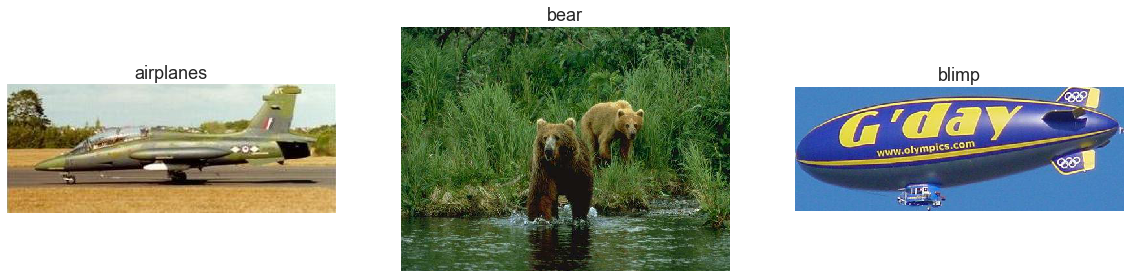

In [19]:
# Displaying the three images from the first three categories in the training set
image_by_label = training_data.groupby("Label").agg({"Image": lambda x: list(x[0])})
image_by_label["Image"] = image_by_label["Image"].apply(np.array)
img1, img2, img3 = image_by_label["Image"].iloc[0], image_by_label["Image"].iloc[1], image_by_label["Image"].iloc[2]
[label1, label2, label3] = image_by_label.index[0:3]

# Plotting images
plt.figure(figsize=(18,8))
f, axes = plt.subplots(figsize=(20,10), ncols=3, nrows=1)

axes[0].imshow(img1)
axes[1].imshow(img2)
axes[2].imshow(img3)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].title.set_text(label_dict[label1])
axes[1].title.set_text(label_dict[label2])
axes[2].title.set_text(label_dict[label3]);

#### Class frequencies

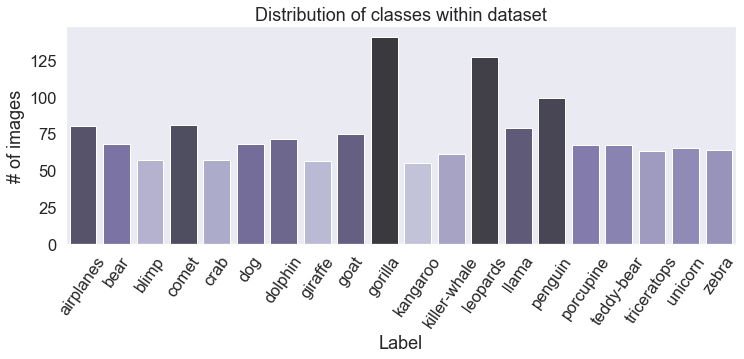

In [20]:
plt.figure(figsize=(12,4))

labels = training_data.groupby("Label")["Image"].count()

pal = sns.color_palette("Purples_d", len(labels))
rank = labels.argsort().argsort()

ax = sns.barplot(x=[label_dict[label] for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within dataset")
plt.ylabel("# of images")
plt.xlabel("Label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);

The distribution is quite balanced, but there are some classes that are more represented than others, e.g. *Gorilla* and *Leopards*. If this becomes an issue, one might consider to down-sample the training set.

#### Graphical summaries of the sizes of the images in addition to pixel intensities

<Figure size 1080x360 with 0 Axes>

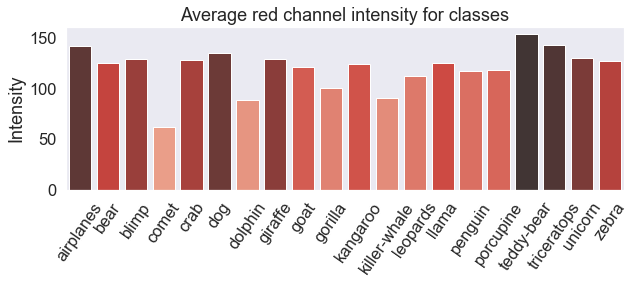

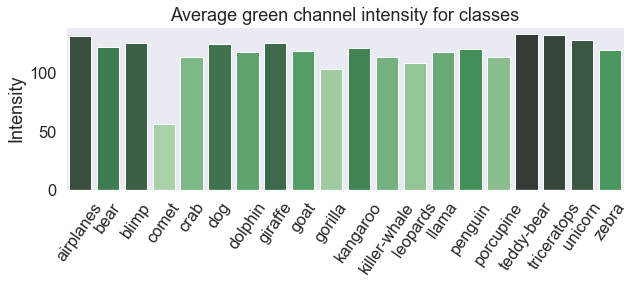

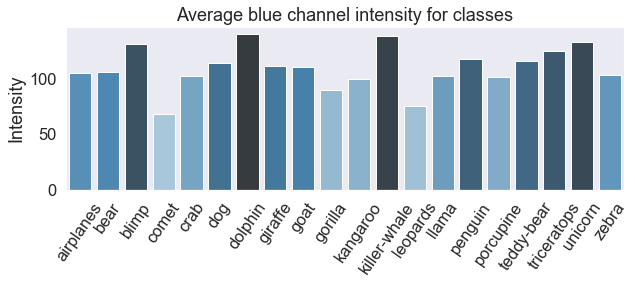

In [21]:
plt.figure(figsize=(15,5))
def calculate_channel_average(img, channel):
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

# Calculating channel average over all labels
red_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="R") for img in s])}).reset_index()
green_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="G") for img in s])}).reset_index()
blue_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="B") for img in s])}).reset_index()

def plot_channel_intensity_barplot(df, channel):
    # Plotting individual plots for channel intensities
    title_dict = {"r": "red", "g": "green", "b": "blue"}
    palet_dict = {"r": "Reds_d", "g": "Greens_d", "b": "Blues_d"}
    plt.figure(figsize=(10,3))

    values = df["Image"].values
    pal = sns.color_palette(palet_dict[channel], len(values))
    rank = values.argsort().argsort()
    ax = sns.barplot(x=[label_dict[label] for label in df["Label"]], y=values, palette=np.array(pal[::-1])[rank])
    
    plt.ylabel("Intensity")
    plt.title(f"Average {title_dict[channel]} channel intensity for classes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=55)

plot_channel_intensity_barplot(red_channel_average, "r")
plot_channel_intensity_barplot(green_channel_average, "g")
plot_channel_intensity_barplot(blue_channel_average, "b");

#### Plotting all channel distribtions together

In [22]:
def set_type_array(channel, df):
    
    df["type"] = [channel for _ in range(len(df))]

set_type_array("red", red_channel_average)
set_type_array("green", green_channel_average)
set_type_array("blue", blue_channel_average)

channel_averages = pd.concat([red_channel_average, green_channel_average, blue_channel_average])

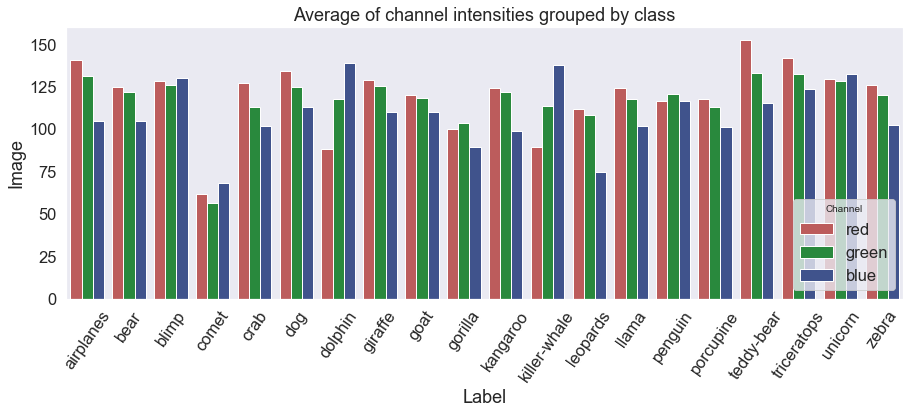

In [23]:
plt.figure(figsize=(15,5))

colors = [[0.8, 0.3, 0.3], [0.1, 0.6, 0.2], [0.2, 0.3, 0.6] ]

ax = sns.barplot(x=[label_dict[label] for label in channel_averages["Label"]], y="Image", hue="type", data=channel_averages, palette=colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);
plt.xlabel("Label")
plt.title("Average of channel intensities grouped by class")
ax.legend(title="Channel",loc="lower right");

#### Distribution of image sizes

Plotting the distribution of image sizes (number of values in a image-vector: $height*width*3$)

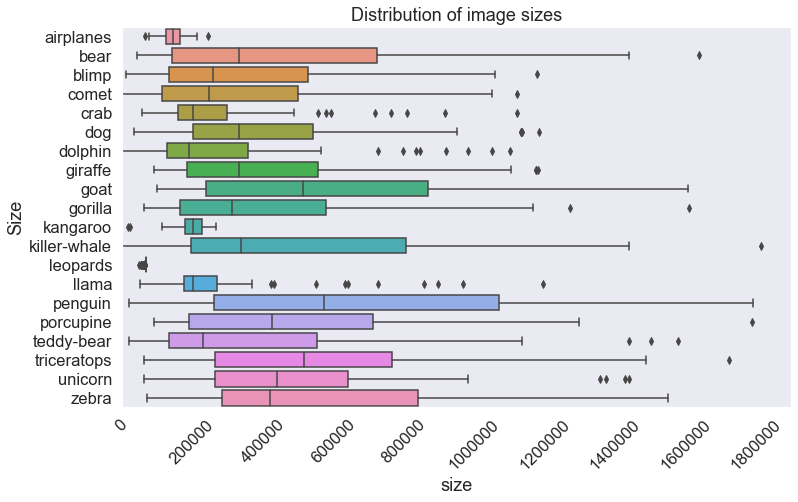

In [24]:
plt.figure(figsize=(12,7))

training_data["size"] = training_data["Image"].apply(np.size)

ax = sns.boxplot(y=[label_dict[label] for label in training_data["Label"]], x="size", data=training_data, orient="h")
plt.title("Distribution of image sizes")
plt.xticks(np.arange(0, 1900000, 200000), rotation=45)
plt.xlim(0, 1900000)
plt.ylabel("Label");
plt.ylabel("Size");

We see that the distribution of image sizes among the different classes appear to be different. Many of the distributions stretches over similar areas, especially between 300,000 and 700,000. A couple of the categories such as; `airplanes`, `kangaroo` and `leopards`, have very small distributions, which indicates that size might be a good feature. 

### Preprocessing

In [25]:
def get_trimmed_image(image):
    """
    Returns image without white border if such border exists.
    If not, returns original image
    """
    imagePIL = Image.fromarray(np.array(image))
    bg = Image.new(imagePIL.mode, imagePIL.size, imagePIL.getpixel((0,0)))
    diff = ImageChops.difference(imagePIL, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        trimmed_img = imagePIL.crop(bbox)
        return np.array(trimmed_img)
    return image

In [26]:
# Trim every image 
training_data['Image'] = training_data['Image'].apply(get_trimmed_image)

Rescaling to h: 311.3757495003331, w: 415.6344491000715


<Figure size 1296x576 with 0 Axes>

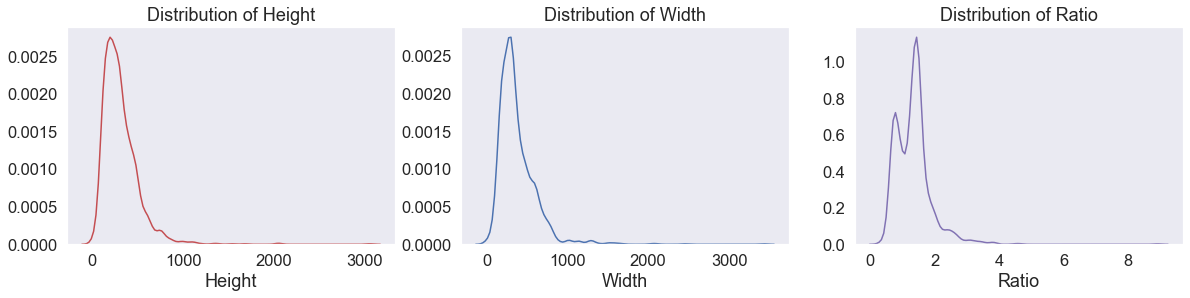

In [27]:
height = training_data["Image"].apply(len)
width = training_data["Image"].apply(lambda x: len(x[0]))
ratio = width/height

# Plotting distributions
plt.figure(figsize=(18,8))

f, axes = plt.subplots(figsize=(20,4), ncols=3, nrows=1)

sns.distplot(height, hist=False, ax=axes[0], color="r")
sns.distplot(width, hist=False, ax=axes[1], color="b")
sns.distplot(ratio, hist=False, ax=axes[2], color="m")

axes[0].set_xlabel("Height")
axes[1].set_xlabel("Width")
axes[2].set_xlabel("Ratio")

axes[0].title.set_text('Distribution of Height')
axes[1].title.set_text('Distribution of Width')
axes[2].title.set_text('Distribution of Ratio')

# Choosing mean heigth and ratio to derive width, to rescale images
mean_ratio = np.mean(ratio)
scale_height = np.mean(height)
scale_width = scale_height * mean_ratio

scaling_size = (int(scale_width), int(scale_height))

print(f"Rescaling to h: {scale_height}, w: {scale_width}");

In [28]:
def get_scaling_size(data):
    """
    Calculating scaling size
    """
    height = data["Image"].apply(len)
    width = data["Image"].apply(lambda x: len(x[0]))
    ratio = width/height
    
    mean_ratio = np.mean(ratio)
    scale_height = np.mean(height)
    scale_width = scale_height * mean_ratio

    return (int(scale_width), int(scale_height))

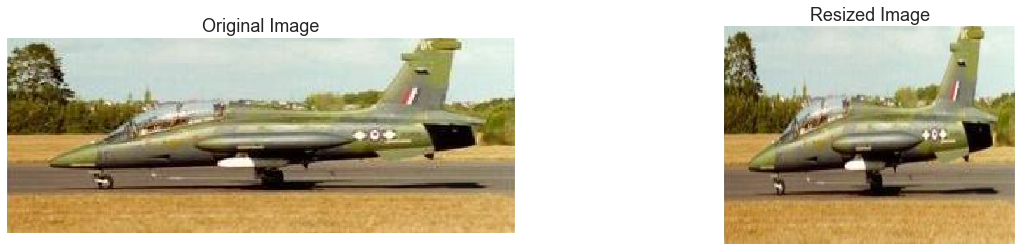

In [29]:
def resize_image(image, size):
    """
    Resizes image to a fixed size
    """
    return cv2.resize(image, size, interpolation = cv2.INTER_AREA)

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)

original_image = training_data.Image[0]
resized_img = resize_image(original_image, scaling_size)

axes[0].imshow(original_image)
axes[1].imshow(resized_img)

axes[0].title.set_text('Original Image')
axes[1].title.set_text('Resized Image')
axes[0].axis('off')
axes[1].axis('off');

##### Scaling images based on width, height and aspect-ratio distribution

In [30]:
training_data["Scaled_Image"] = training_data["Image"].apply(resize_image, args=(scaling_size,))

### Feature extraction

#### Proposed features:

* Image size
* Avg red-channel intensity
* Avg green-channel intensity
* Avg blue-channel intensity
* Aspect-ratio
* Channel stride averages
* Flattened RGB 3D-Histogram
* Average gray-scale intensity
* Count of circles using Hough Transform
* SIFT - Scale Invariant Feature Transform


In [31]:
def image_size(image):
    """
    Returns the pixel size of the image
    """
    return image.size

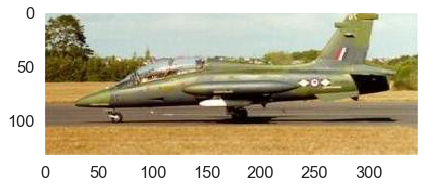

In [32]:
def average_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.mean(channel_intensities)

average_channel_intensity(training_data.Image[0], "R")
show(training_data.Image[0])

In [33]:
def aspectratio(image):
    """
    Returns the aspect ratio of the image (width/height)
    """
    return len(image[0])/len(image)

aspectratio(training_data.Image[0])

2.601503759398496

##### Exploring the use of color histograms
A color histogram represents the distribution of colors in an image. Our motivation to try this is that different images will have different color distribution. For instance, an image of an airplane on a runway will typically have more dark colors than a leopard on the savannah. So their different color distribution seems like a useful feature to include. Also, it can especially be a helpful feature to distinguish between images where the main object is similar, but the background differs. For instance, an image of a bear in the woods and an image of a teddybear in a bed would seem quite similar when only considering the main object (the bear and the teddybear), but when also considering the background it becomes easier to distinguish the two. 

Here we will explore the use of color histograms, first for gray-scaled images, then for images with RGB-tuples. We will use the cv2.calcHist function from OpenCV to build our histograms.

In [34]:
def get_grayed_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

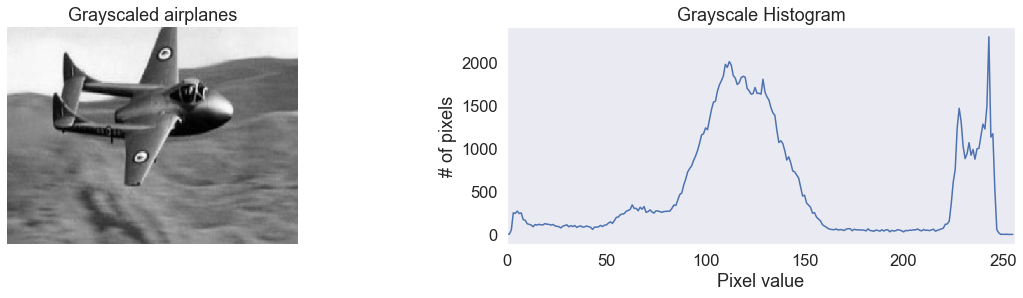

In [35]:
def get_gray_histogram(image):
    """
    cv2.calcHist(images, channels, mask, histSize, ranges)
    # images: list of images we want to compute histogram for
    # channels: list of indexes, specifies the index of the channel we want to compute the histogram for
    For a gray scaled this is [0], for RGB-image this is [0, 1, 2]
    # mask: does not use this
    # histSize: number of bins to use. Must be specified for each channel.
    Here we use 256 bins
    # ranges: possible pixle values, normally between 0 and 256.
    """
    # Convert to grayscale
    grayed_img = get_grayed_image(image)
    return cv2.calcHist([grayed_img], [0], None, [256], [0, 256])

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)

# Showing the grayed image
image_with_label = training_data.loc[53, ['Scaled_Image', 'Label']]
image, label = image_with_label['Scaled_Image'], image_with_label['Label']

axes[0].imshow(get_grayed_image(image), cmap='gray')
axes[0].title.set_text(f'Grayscaled {label_dict[label]}')
axes[0].axis('off')

hist = get_gray_histogram(image)
hist = hist.flatten()

# Plotting the distribution
plt.title('Grayscale Histogram')
plt.xlabel('Pixel value')
plt.ylabel('# of pixels')
plt.xlim(0, 256)
axes[1].plot(hist);


As we can see, the histogram detects many pixels that are medium dark (has values of \~100 to \~150). It seems reasonable to believe that these correspond to the surface of the airplane. Also, the histogram detects many quite light pixels (\~200 to \~220), which we believe corresponds to the bright sky.

Computing a histogram for each color:

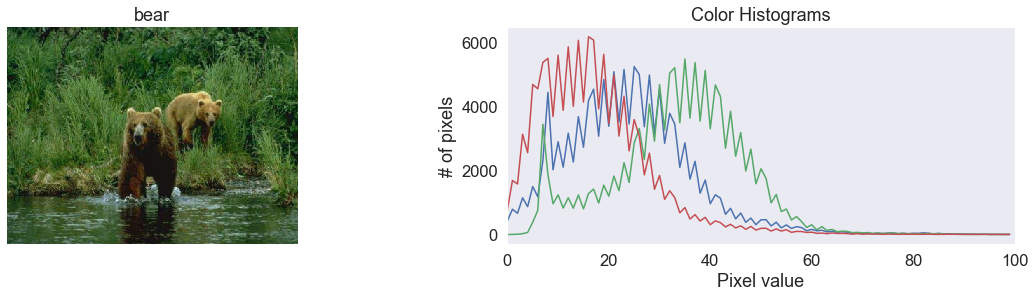

In [36]:
def get_color_histograms(image):
    channels_values = cv2.split(image)
    colors = ("b", "g", "r") # cv2 splits in reverse order 
    hist_list = []
    for (channel, color) in zip(channels_values, colors):
        #Creating a histogram for the current histogram, combining them later
        hist = cv2.calcHist([channel], [0], None, [100], [0, 256])
        hist_list.append(hist)

    return hist_list

f, axes = plt.subplots(figsize=(20,4), ncols=2, nrows=1)
img = training_data.loc[80, 'Scaled_Image']

axes[0].imshow(img)
axes[0].axis("off")
axes[0].title.set_text(label_dict[training_data.loc[80, 'Label']])
histograms = get_color_histograms(img)

# Plotting the distribution
plt.title('Color Histograms')
plt.xlabel('Pixel value')
plt.ylabel('# of pixels')
plt.xlim(0, 100)
colors = ['b', 'g', 'r']
for i, hist in enumerate(histograms):  
    axes[1].plot(hist, color=colors[i]);

So far we computed histograms for one color (channel) at the time. To get better features we now compute multi-dimensional histograms. This will give us more informative features that looks at the combination of all three colors. For instance, we now will get a count for how many pixels has a red value of 10, a green value of 30 and a blue value of 60.

Here we use 8 bins for each channel, which results in a feature vector of size 8x8x8 = 512.
This means that one of the bins will count the number of pixels in an image that has red values 0-32, green values 0-32 and blue values 0-32, one bin will count the number of pixels that has red values 0-32, green values 0-32 and blue values 33-64, and so on.  

Computing a 3D histogram:

In [37]:
def get_3D_color_histogram(image, num_bins=8):
    """
    Extracting a 3D color histogram for the RGB (Red, Green, Blue) space using 8 bins for each of these channels
    """
    bins = [num_bins]*3
    #print(image)
    hist = cv2.calcHist([image], [0,1,2], None, bins, [0,256,0,256,0,256])
    #cv2.normalize(hist, hist)
    return hist.flatten()


img = training_data.loc[80, 'Scaled_Image']
histograms = get_color_histograms(img)
mult_dim_histograms = get_3D_color_histogram(img)
print(f"# of features of 3D color histogram for one image: {mult_dim_histograms.shape}")

# of features of 3D color histogram for one image: (512,)


In [38]:
def add_hist_features(df, column):
    """
    Method for computing 3d histograms for column in dataframe, 
    and adding the resulting feature vector as columns in the dataframe
    """
    hist_features = df[column].apply(lambda l: get_3D_color_histogram(l))
    hist_features = np.array([feat for feat in hist_features])
    prefix= 'hist_feat_'
    for i in range(len(hist_features[0])):
        feat_name = prefix+str(i)
        df[feat_name] = hist_features[:,i]

#### Average channel-intensities of image strides

Motivation: Lorem Ipsum

In [39]:
def calculate_stride_channel_averages(image):
    """
    Sliding non-overlapping strides over the image and calculating the average channel intensities for each stride
    Returning the flattened matrix containing the average RGB values for each stride.
    """

    no_width_strides = 5
    height, width = len(image), len(image[0])#scaling_size
    stride_length = width // no_width_strides
    stride_channel_avgs = []
    for i in range(no_width_strides - 1):
        height_start, height_end = stride_length * i, stride_length * (i+1)
        for j in range(no_width_strides - 1):
            width_start, width_end = stride_length * j, stride_length * (j+1)

            pixels = image[height_start : height_end][:, width_start : width_end]
            pixels = pixels.reshape(-1, pixels.shape[-1])
            r = np.mean(pixels[:, 0])
            g = np.mean(pixels[:, 1])
            b = np.mean(pixels[:, 2])

            stride_channel_avgs.append([r, g, b])

    return np.array(stride_channel_avgs).flatten()



#calculate_stride_channel_averages(training_data["Scaled_Image"][1])

In [40]:
def add_stride_features(df, column):
    """
    Method that computes average channel intensities for each stride for one column in dataframe, 
    and adding the resulting feature vector as columns in the dataframe
    """
    stride_features = df[column].apply(lambda l: calculate_stride_channel_averages(l))
    stride_features = np.array([feat for feat in stride_features])
    prefix= 'stride_feat_'
    for i in range(len(stride_features[0])):
        feat_name = prefix+str(i)
        df[feat_name] = stride_features[:,i]
    
add_stride_features(training_data, 'Scaled_Image')
training_data.head(2)

,Image_Id,Image,Label,size,Scaled_Image,stride_feat_0,stride_feat_1,stride_feat_2,stride_feat_3,stride_feat_4,...,stride_feat_38,stride_feat_39,stride_feat_40,stride_feat_41,stride_feat_42,stride_feat_43,stride_feat_44,stride_feat_45,stride_feat_46,stride_feat_47
0,0,"[[[202, 211, 208], [198, 209, 205], [195, 207,...",0,141168,"[[[202, 211, 208], [199, 209, 206], [196, 208,...",158.797648,164.638264,146.259544,204.310350,217.362317,...,69.024485,200.337738,154.024291,77.914302,204.685581,159.065099,84.167120,207.603770,162.122037,85.921687
1,1,"[[[255, 248, 227], [255, 248, 227], [255, 247,...",0,188232,"[[[255, 248, 227], [255, 248, 227], [255, 248,...",234.200755,101.508201,86.003919,245.636377,235.361301,...,204.039059,234.958609,226.521764,197.335600,229.863778,219.532452,190.065682,180.765449,166.182083,139.374854


#### Grayscale Intensity of Image

In [41]:
def grayscale_intensity(image):
    """
    Calculating the average grayscale intensity for all pixels given an image
    """
    grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(grayscaled_image)

print("Airplane:", grayscale_intensity(training_data["Scaled_Image"][1]))
print("Comet:", grayscale_intensity(training_data["Scaled_Image"][33]))

Airplane: 145.1856506411498
Comet: 108.22952000929764


#### Number of circles in an image using Hough Transform
OpenCV provides an implementation of Hough Transform, by using Hough Gradient Method with gradient information of edges to find circles in images.

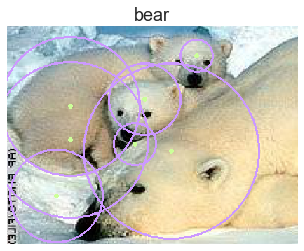

In [42]:
def find_hough_circles(image, visualize=False):
    img = image.copy()
    img = cv2.medianBlur(img, 9)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Finding circles using Hough Transform
    circles = cv2.HoughCircles(gray_img,
                               cv2.HOUGH_GRADIENT,
                               dp=1,
                               minDist=40,
                               param1=30,
                               param2=50,
                               minRadius=0,
                               maxRadius=130)
    
    return circles if circles is not None else np.array([[[]]])


def visualize_hough_circles(image):
    img = image.copy()
    circles = find_hough_circles(img);
    if circles.shape[2] != 0:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # Draw circle
            cv2.circle(img,(i[0],i[1]),i[2], (204, 153, 255), 2)

            # Draw center of circle
            cv2.circle(img,(i[0],i[1]), 2, (204, 255, 153), 2)

    plt.imshow(img)
    plt.axis("off")
    plt.title(label_dict[training_data.loc[80, 'Label']]);

    
img = training_data["Scaled_Image"][94]
visualize_hough_circles(img)

In [43]:
# Counting circles for all images
training_data['Circle_Count'] = training_data["Scaled_Image"].apply(lambda img: find_hough_circles(img).shape[1])

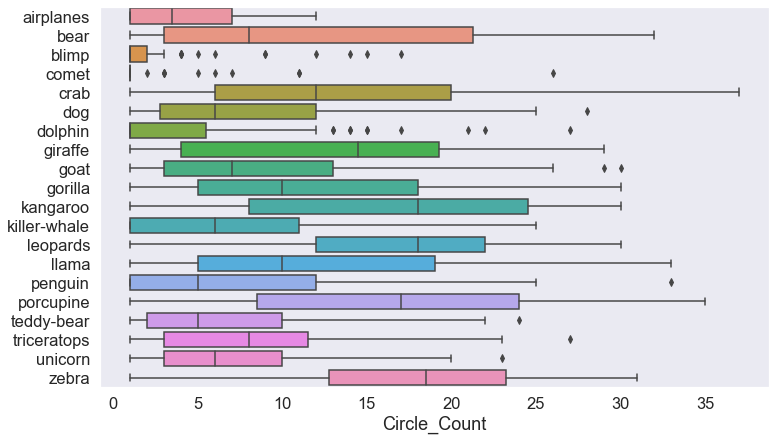

In [44]:
# Visualizing feature distribution

plt.figure(figsize=(12,7))
ax = sns.boxplot(y=[label_dict[label] for label in training_data["Label"]], x="Circle_Count", data=training_data, orient="h")

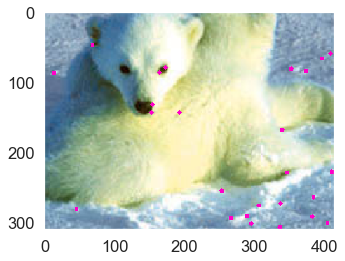

In [101]:
def get_harris_corners(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    corners = cv2.goodFeaturesToTrack(gray, 25, 0.01, 10)
    corners = np.int0(corners)
    return corners

def visualize_harris_corners(img):
    image = img.copy()
    corners = get_harris_corners(image)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(image, (x, y), 3, (255, 0, 200), -1)

    plt.imshow(image)
    plt.show();
    
img = training_data["Scaled_Image"][103].copy()
visualize_harris_corners(img)

#### SIFT - Scale Invariant Feature Transform

SIFT is a method for images' extracting feature vectors that describe local patches. These features are scale-invariant, as well as invariant to transaltion, rotation and illumination. Therefore we have chosen this to be a good descriptor of our images. Using OpenCV's implementation of SIFT.

Tutorial to install an OpenCV version that has not removed SIFT and SURF, which the newer versions have. We used this tutorial, https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal, and got it installed using the anaconda bash-command `conda install -c menpo opencv` which will install Open CV version `3.4.1`. Since you may not be able to install correctly, we have stored the descriptors for the training images in a file called `descriptors.csv`, which are read when preprocessing.

###### SIFT Keypoints

A SIFT *keypoint* is a circular image region with an orientation. It is described by coordinates x and y, its scale (the radius of the region), and its orientation.

First we will show an example of how SIFT finds keypoints in an image. The code under uses SIFT to extract keypoints and then visualizing these keypoints. Each keypoint is visualized by an circle that varies in size and color. The color and size of the circles represents the size of the region for each keypoint. Small regions has red color, intermediate regions has orange color, and big regions has green color. The size of the circles represents variation of region size within each color. 

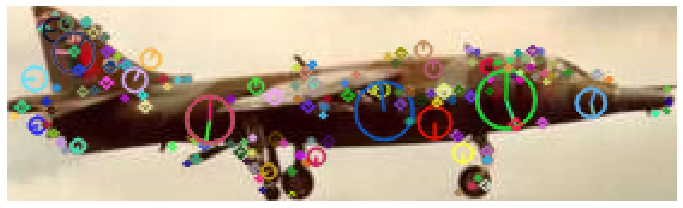

In [58]:
plt.figure(figsize=(12,7))

def visualize_keypoints(image):
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img2 = cv2.drawKeypoints(img, kp,  outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(img2)
    plt.axis("off");

img = training_data["Image"][13] #0
visualize_keypoints(img)

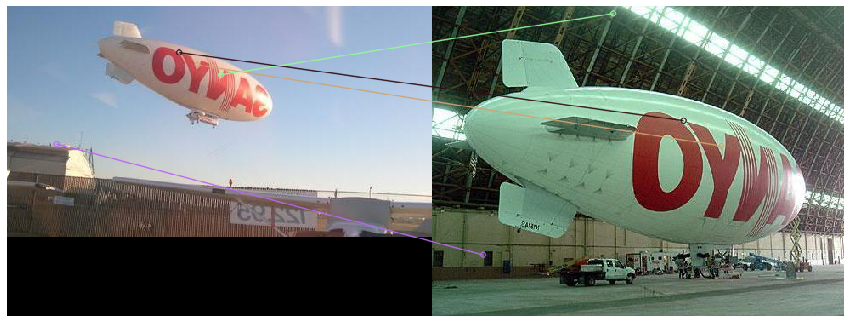

In [47]:
plt.figure(figsize=(15,10))

img1, img2 = training_data["Image"][187], training_data["Image"][170]


sift = cv2.xfeatures2d.SIFT_create()
gray1, gray2 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# BFMatcher with default params
bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, flags=2, outImg=np.array([]))

plt.imshow(img3)
plt.axis('off')
plt.show();

It looks like SIFT does a reasonably good job at detecting keypoints in an image. And is performing well at matching keypoints and descriptors of similar objects in different angles, rotation and scale. 


##### SIFT Descriptors

Now we have a method for extracting keypoints in images. As said, each keypoints consists of x, y, scale and orientation. One thought is to extract color intensities from each keypoint region in an image, and using these values as features. However, SIFT also provides *descriptors* for each keypoint. These descriptors are even more informative than raw color intensity values, so we will use these descriptors as features instead.

In [48]:
def get_descriptors(img, sift=None):
    sift = sift if sift else cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, descriptors = sift.detectAndCompute(gray, None)
    
    return np.array(descriptors) if descriptors is not None else np.array([])

img = training_data["Scaled_Image"][3].copy()
descs = get_descriptors(img)
descs.shape

(1174, 128)

###### Bag of visual words

Now we have a method for extracting SIFT descriptors for each keypoint in an image. Next is to use the descriptors as features. We will use a "bag of visual words" method to accomplish this.

Intuitively, we look at each descriptor as a visual word. We imagine that one descriptor represents for instance a wheel, while another represents an eye. Each image consists of a collection of such visual words. Then we want to collect every visual words from all images in our training set. This collection will then consist of every possible descriptor from all images. 

However, the descriptors does not have a human-meaningful meaning (such as a wheel or an eye), so we want to group similar descriptors together. 
Therefore we will make clusters of descriptors, such that each group of descriptors captures some broader feature.

Descriptors are 128-dimensional vectors, so we make a dataframe with 128 columns from all of the descriptors in our training set. Next we use KMeans clustering algorithm to find K groups (bins) of descriptors. We can imagine that there will be a group for wheels that contains all descriptors that represent a wheel. 

Then, when evaluating a new image (not from training set) we assign each descriptor to the group they belong to. Then we will count the number of descriptors that was categorized into group 1, the number of descriptors that was categorized into group 2, etc. 
Essentially we are building a histogram for the different descriptors.

This means that SIFT ultimately will contribute with K new features, where the K'th feature represents a count of how many descriptors that belongs to the K'th cluster.

In [53]:
def get_all_descriptors(images, labels, images_ids):    
    """
    Method that collects all descriptors from a series of images and puts them in a dataframe with 128 columns
    Also collecting labels for future plotting 
    """
    images = images.values
    start_time = timer()
    descriptor_matrix = []
    desc_labels = []
    desc_images_id = []
    sift = cv2.xfeatures2d.SIFT_create()
    print(f"Processing {len(images)} images")
    for i, img in enumerate(images):
        descriptors = get_descriptors(img, sift)
        label = labels.iloc[i] if labels is not None else None
        image_id = images_ids.iloc[i]

        if len(descriptors) != 0:
            desc_labels.extend([label]*len(descriptors))
            descriptor_matrix.append(descriptors)
            desc_images_id.extend([image_id]*len(descriptors))
        print(f"[{((i + 1)/len(images))*100:.1f}%] Processed {i + 1} images. Time elapsed: {timer() - start_time:.1f} s", end='\r')
    
    descriptor_df = pd.DataFrame(np.concatenate(descriptor_matrix))
    descriptor_df['Image_Id'] = np.array(desc_images_id)
    descriptor_df['Label'] = np.array(desc_labels)

    return descriptor_df




In [56]:
# Making a dataframe of all descriptors from all images 
# Adding ImageId and label for each descriptor so that we can extract them later,
# without having to compute them again
def find_and_save_descriptors_to_file(train_data=None, test_data=None):
    if train_data is not None:
        print("Creating descriptors for training data:")
        ids, labels, images =  train_data['Image_Id'], train_data['Label'], train_data['Image']
        train_descriptor_df = get_all_descriptors(images, labels, ids)
        train_descriptor_df.to_csv('descriptors_train.csv', index=False)
        
    if test_data is not None:
        print("\nCreating descriptors for testing data:")
        ids, images =  test_data['Image_Id'], test_data['Image']
        test_descriptor_df = get_all_descriptors(images, None, ids)
        test_descriptor_df.to_csv('descriptors_test.csv', index=False)
        
    return train_descriptor_df, test_descriptor_df

In [55]:
# Saving all descriptors from all images in training data to file 
# Later, when we split in training and test data, we locate the discriptors images by their image Id
# Only descriptors from training images will be used in the training
create_descriptor_files = True
if create_descriptor_files:
    find_and_save_descriptors_to_file(training_data, testing_data)

Creating descriptors for training data
Processing 1501 images
Creating descriptors for testing dataelapsed: 68.2 s
Processing 716 images


### Using the descriptors to visualize and fit KMeans model

In [61]:
y = training_data.copy()['Label']
x = training_data.copy().drop(columns=['Label'])

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(1200, 53)
(301, 53)


In [65]:
def get_descriptors_for_data(data, descriptor_df):
    """
    Method that gets the descriptors for the corresponding data
    """
    descriptors = descriptor_df.loc[descriptor_df['Image_Id'].isin(data['Image_Id'])]
    return descriptors

In [111]:
def build_descriptor_dict(descriptor_df):
    """
    Method for putting descriptors in a dictionary with image ID as key, to make later retrieval faster
    """
    desc_df = descriptor_df.copy()
    if 'Label' in desc_df.columns:
        desc_df.drop(columns=['Label'], inplace=True)
        
    descriptor_dict = {}
    for i, descr in desc_df.iterrows():
        image_id = descr['Image_Id']
        descriptors = list(descr)[:-1] # Exclude the image id from the descriptor
        if image_id in descriptor_dict:
            descriptor_dict[image_id].append(descriptors)
        else:
            descriptor_dict[image_id] = [descriptors]
    return descriptor_dict


###### Loading descriptors

In [67]:
descriptor_df = pd.read_csv('descriptors_train.csv')
descriptor_dict = build_descriptor_dict(descriptor_df) 

In [68]:
# Getting descriptors that corresponds to images in train_x and test_x
train_descriptors = get_descriptors_for_data(x_train, descriptor_df)
test_descriptors = get_descriptors_for_data(x_test, descriptor_df)

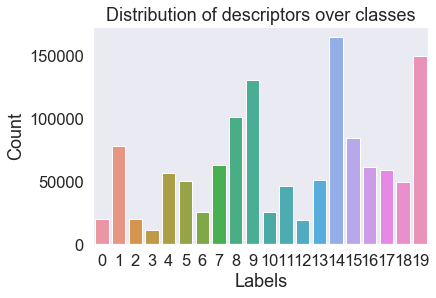

In [69]:
# Checking the distribution of descriptors over all classes
sns.barplot(train_descriptors['Label'].value_counts().index, train_descriptors['Label'].value_counts().values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Distribution of descriptors over classes");

We see that the distribution of descriptors of training images is highly biased. Therefore we set a max limit for the number of predictors for a class at 10000. 

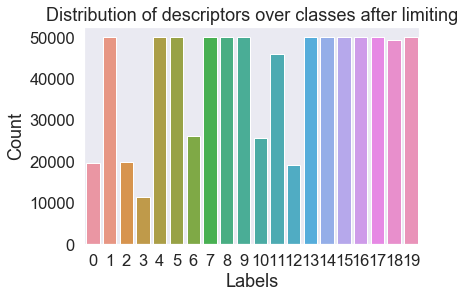

In [70]:
train_descriptors = train_descriptors.groupby('Label').head(50000)
sns.barplot(train_descriptors['Label'].value_counts().index, train_descriptors['Label'].value_counts().values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Distribution of descriptors over classes after limiting");

This distribution look much better. We still see that some of the labels have less descriptors than other. We do not want to set upper limit of descriptors to the minimum number of descriptors (here around 50000), because we then will loose to much information from the descriptors.

Next we will use the train descriptors to find the k groups.
First we need the find the optimal k.

In [71]:
train_descriptors_y = train_descriptors['Label']
train_descriptors_x = train_descriptors.drop(columns=['Label', 'Image_Id'])
test_descriptors_y = test_descriptors['Label']
test_descriptors_x = test_descriptors.drop(columns=['Label', 'Image_Id'])

Using the elbow method to find the optimal k (# of groups to use). 

In [72]:
def elbow_method():
    sum_of_squared_distances = []
    K = range(1, 500, 50)
    for k in K:
        km = KMeans(n_clusters=k, n_init=1, max_iter=50)
        km = km.fit(train_descriptors_x)
        sum_of_squared_distances.append(km.inertia_)
        print(f"Done for k={k}")

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

#elbow_method()

In [73]:
optimal_k = 10 # Found from elbow method above

In [74]:
def get_cluster_distribution(preds, k):
    preds = np.append(preds, [i for i in range(k)]) # To make sure that each cluster gets represented
    unique, counts = np.unique(preds, return_counts=True)
    counts = dict(zip(unique, counts))
    # Get proportion of descriptors in each bin
    props = np.array(list(counts.values()))/len(preds)
    return props

In [75]:
k = optimal_k
km = KMeans(n_clusters=optimal_k)
km.fit(train_descriptors_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We want the model to predict clusters for every descriptor of an image. Then we count the number of clusters that the descriptors is assigned and finds the proportion of descriptors in each cluster.
Let's visualize this for one image.

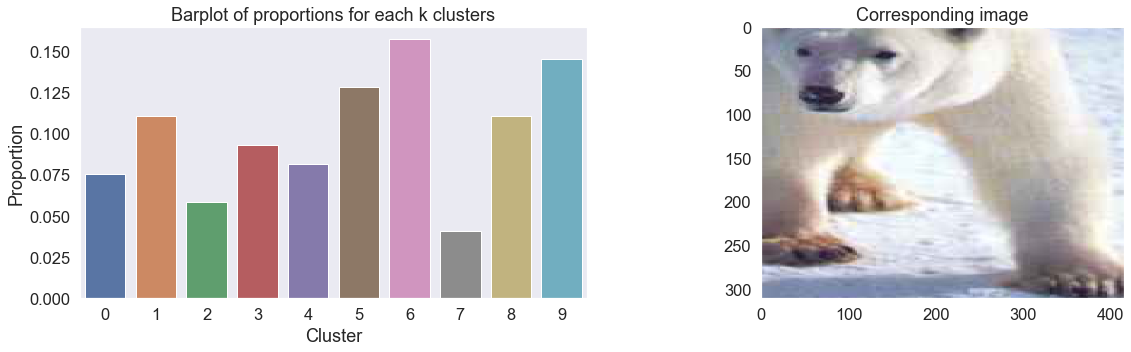

In [76]:
img_id = 100
image_row = training_data.loc[training_data['Image_Id'] == img_id]
label = image_row['Label']
image = image_row['Scaled_Image'].iloc[0]
descriptors = descriptor_dict[img_id]

preds = km.predict(descriptors)
# Get proportion of descriptors in each bin
props = get_cluster_distribution(preds, k)

f, axes = plt.subplots(figsize=(20, 5), ncols=2, nrows=1)
sns.barplot([i for i in range(k)], props, ax=axes[0])
axes[1].imshow(image);
limits = axes[0].get_ylim();

axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Proportion")
axes[0].title.set_text('Barplot of proportions for each k clusters')

axes[1].title.set_text('Corresponding image')

In [77]:
def get_cluster_distributions(model, images, k):
    cluster_dists = []
    for i, row in images.iterrows():
        try:
            img_id = row['Image_Id']
            descriptors = descriptor_dict[img_id]
            preds = model.predict(descriptors)
            cluster_dist = get_cluster_distribution(preds, k)
            cluster_dists.append(cluster_dist)
        except ValueError and KeyError: # This may happen if SIFT fails to exteact descriptors
            continue
    return cluster_dists

In [78]:
def visualize_cluster_distributions(cluster_dists, palette):
    palette = sns.color_palette(palette, len(cluster_dists))
    f, axes = plt.subplots(figsize=(20, 5), ncols=2, nrows=1)
    
    boxplot_df = pd.DataFrame()
    for i in range(len(cluster_dists[0])):
        boxplot_df[i] = np.array(cluster_dists)[:, i]
    sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_df), ax=axes[0])
    
    for i, arr in enumerate(cluster_dists):
        sns.lineplot([i for i in range(len(cluster_dists[0]))], arr, color=palette[i], ax=axes[1])
    
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Distribution")
    axes[0].title.set_text('Boxplot distribution for each k clusters')
    axes[0].set_ylim(0, 0.5)
    axes[1].set_xlabel("Cluster")
    axes[1].set_ylabel("Proportion")
    axes[1].title.set_text('Lineplot for descriptors of each image')
    axes[1].set_ylim(0, 0.5)
    
    plt.show()

Visualizing the descriptors from all images of airplanes (label 0):

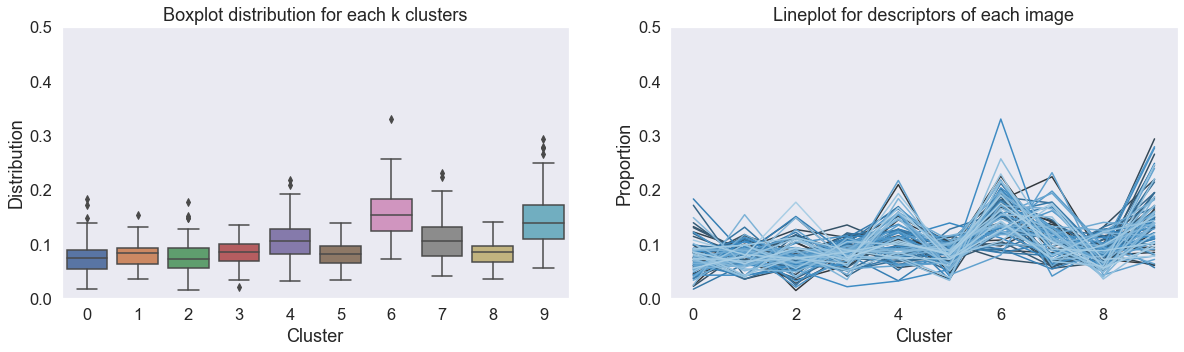

In [79]:
label = 0
label_images = training_data.loc[training_data['Label']==label]
cluster_dists = get_cluster_distributions(km, label_images, optimal_k)
visualize_cluster_distributions(cluster_dists, 'Blues_d')

Visualizing the descriptors from all images of comets (label 3):

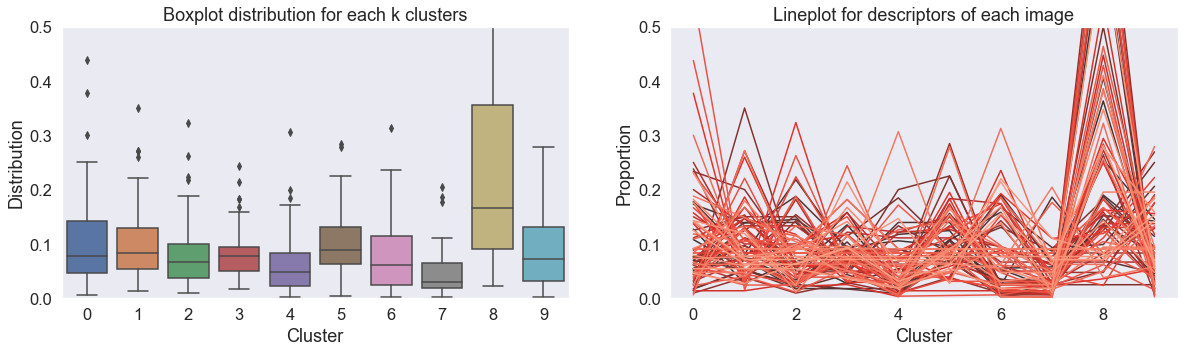

In [80]:
label = 3
label_images = training_data.loc[training_data['Label']==label]
cluster_dists = get_cluster_distributions(km, label_images, optimal_k)
visualize_cluster_distributions(cluster_dists, 'Reds_d')

We notice from the two distribution plots that the cluster proportion differs between the two classes. This incicated that this could be useful features.

##### Feature extraction of cluster proportions

Now we take the cluster proportions of descriptors for each image and add them as features.

For each image we do the following:

1) Find its descriptors

2) Assign each descriptor to a bin (cluster) 

3) Find the proportion of descriptors that went into each cluster

4) Add these k proportions as features 


In [81]:
def get_cluster_features_for_image(img_id, descriptor_dict, model, k):
    #descriptors = get_descriptors_from_file(img_id, descriptor_df)
    try:
        descriptors = descriptor_dict[img_id]
        preds = model.predict(descriptors)
    except: # If SIFT fails to find descriptors we simply return uniform distribution of clusters 
        preds = [i for i in range(k)]
        #print("SIFT unable to load descriptors")
    cluster_dist = get_cluster_distribution(preds, k)
    return cluster_dist

In [82]:
def get_cluster_features_for_all_images(df, descriptor_dict, model, k):
    cluster_features = []
    cluster_distribution = df['Image_Id'].apply(lambda i: get_cluster_features_for_image(i, descriptor_dict, model, k)) 
    for row in cluster_distribution:
        cluster_features.append(row)
    return np.array(cluster_features)

In [83]:
def add_cluster_features_to_df(df, descriptor_dict, model, k):
    cluster_features = get_cluster_features_for_all_images(df, descriptor_dict, model, k)
    for i in range(k):
        column = f"descriptor_cluster_{i}"
        df[column] = cluster_features[:, i]    

In [84]:
add_cluster_features_to_df(training_data, descriptor_dict, km, optimal_k)

 We expect all external sources sited, and significant indication of EDA. 

<h4> Collecting the preprocessing in one method </h4>

In [115]:
def get_preprocessed_feature_frame(df_train=None, df_test=None, downsample=False, validation_size=0.1, k=10):
    """
    Returns preprocessed data with all features
    """
    
    print("[INFO] Beginning preprocessing part one")
    
    if df_train is None:
        df_train, _ = read_training_data()
    
    if df_test is None:
        df_test = read_testing_data()
    
    if downsample:
        print("[INFO] Downsampling training images..")
        for label in [9, 12, 14]:
            dropping_indices = df_train[df_train['Label']==label].index
            dropping = np.random.choice(dropping_indices, 75, replace=False)
            df_train = df_train.drop(dropping)
    
    scaling_size = get_scaling_size(df_train)
    for data in [df_train, df_test]:
        print("[INFO] Denoising images")
        data['Image'] = data['Image'].apply(lambda img: cv2.medianBlur(img, 3))    
        
        print("[INFO] Trimming images")
        data['Image'] = data['Image'].apply(get_trimmed_image)
    
        print("[INFO] Scaling images")
        data["Scaled_Image"] = data["Image"].apply(lambda i: resize_image(i, scaling_size))

        print("[INFO] Counting Hough Transform circles")
        data['Circle_Count'] = data["Scaled_Image"].apply(lambda img: find_hough_circles(img).shape[1])

        print("[INFO] Adding features: size, aspect_ratio, red-, green-, blue- and gray-intensity")
        data['Size'] = data['Image'].apply(image_size)
        data['AspectRatio'] = data['Image'].apply(aspectratio)
        data['Red_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'R'))
        data['Green_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'G'))
        data['Blue_intensity'] = data['Scaled_Image'].apply(lambda i: average_channel_intensity(i, 'B'))
        data['Grayscale_intensity'] = data['Scaled_Image'].apply(grayscale_intensity)

        print("[INFO] Adding histogram features")
        add_hist_features(data, 'Scaled_Image')

        print("[INFO] Adding stride features")
        add_stride_features(data, 'Scaled_Image')

        data.drop(columns=['Image', 'Scaled_Image'], inplace=True)
        
    train_df_part, val_df_part = train_test_split(df_train, test_size=validation_size)  
        
    print("[INFO] Getting descriptors")
    train_val_descriptor_df = pd.read_csv('descriptors_train.csv')
    test_descriptor_df = pd.read_csv('descriptors_test.csv')
    
    print("[INFO] Building descriptor dictionary")
    descriptor_dict_train_val = build_descriptor_dict(train_val_descriptor_df)
    descriptor_dict_test = build_descriptor_dict(test_descriptor_df)
    
    print(f"[INFO] Fitting KMeans with k={k} to training descriptors")
    # Finding training descriptors to fit KMeans
    train_descriptors = get_descriptors_for_data(train_df_part, train_val_descriptor_df)
    
    # Unbias the train descriptors by selecting the 50,000 first from each label
    train_descriptors = train_descriptors.groupby('Label').head(50000)
    
    # Prepare train descriptors
    train_descriptors_x = train_descriptors.drop(columns=['Label', 'Image_Id'])
    
    # Scaling descriptors
    scaler = MinMaxScaler()
    train_descriptors_x_scaled = scaler.fit_transform(train_descriptors_x)
    
    km = KMeans(n_clusters=k)
    km.fit(train_descriptors_x_scaled)
    
    print("[INFO] Adding cluster features")
    add_cluster_features_to_df(train_df_part, descriptor_dict_train_val, km, k)
    add_cluster_features_to_df(val_df_part, descriptor_dict_train_val, km, k)
    add_cluster_features_to_df(df_test, descriptor_dict_test, km, k)
    
    train_df_part.drop(columns=['Image_Id'], inplace=True)
    val_df_part.drop(columns=['Image_Id'], inplace=True)
    df_test.drop(columns=['Image_Id'], inplace=True)
    
    print("[INFO] Done preprocessing")
    
    return train_df_part, val_df_part, df_test

<h4> Sources </h4>

* https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/
* Averaging colors: https://dev.to/wunk/average-color-of-an-image-vectorized-4802
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html#hough-circles

* SIFT: 
   * https://www.cse.unr.edu/~bebis/CS491Y/Papers/Lowe04.pdf
   * https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
   * https://medium.com/@lerner98/
   * Source-code: https://github.com/SamL98/PySIFTimplementing-sift-in-python-36c619df7945
   * https://ianlondon.github.io/blog/how-to-sift-opencv/
   * https://ianlondon.github.io/blog/visual-bag-of-words/
   
